# Constants

In [1]:
import os
import requests
import zipfile
from pathlib import Path
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from dataclasses import dataclass
from typing import List, Dict, Optional
import json
# You can place this in a utilities cell/file.
import re
from datetime import datetime, timezone
from typing import Optional, Iterable
import pandas as pd
import json
import yaml

/home/ahmed.bargady/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# change it to the path where you wanna put your data
BASE_PATH = Path("/home/ahmed.bargady/lustre/data_sec-um6p-st-sccs-6sevvl76uja/IDS/ahmed.bargady/datasets/temp/prod")
# BASE_PATH = Path("path_to_your_folder_of_work")

In [3]:
DATASETS = ['Linux24APT', 'russellmitchell', 'santos', 'wardbeck', 'shaw','wilson', 'fox']
len(DATASETS)

7

In [5]:
PATHS = {
    name: BASE_PATH / f"{name}_all.csv" for name in DATASETS
}

In [6]:
def load_prod(file_path, cols=None):
    df = pd.read_csv(file_path, low_memory=False)
    if cols:
        df = df[cols]
    return df

In [7]:
data = {
    name: load_prod(p, ['Content', 'Label']) for name, p in PATHS.items()
}

# Analysis

In [9]:
_FONT_SIZE = 24
_FS = 22

In [8]:
counts = {
    name: {"Total": len(df), "Normal": df[df['Label'] == 0].shape[0], "Anomalous": df[df['Label'] == 1].shape[0]}
    for name, df in data.items()
}

<ipython-input-10-f8d72cd9057f>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=_FS)


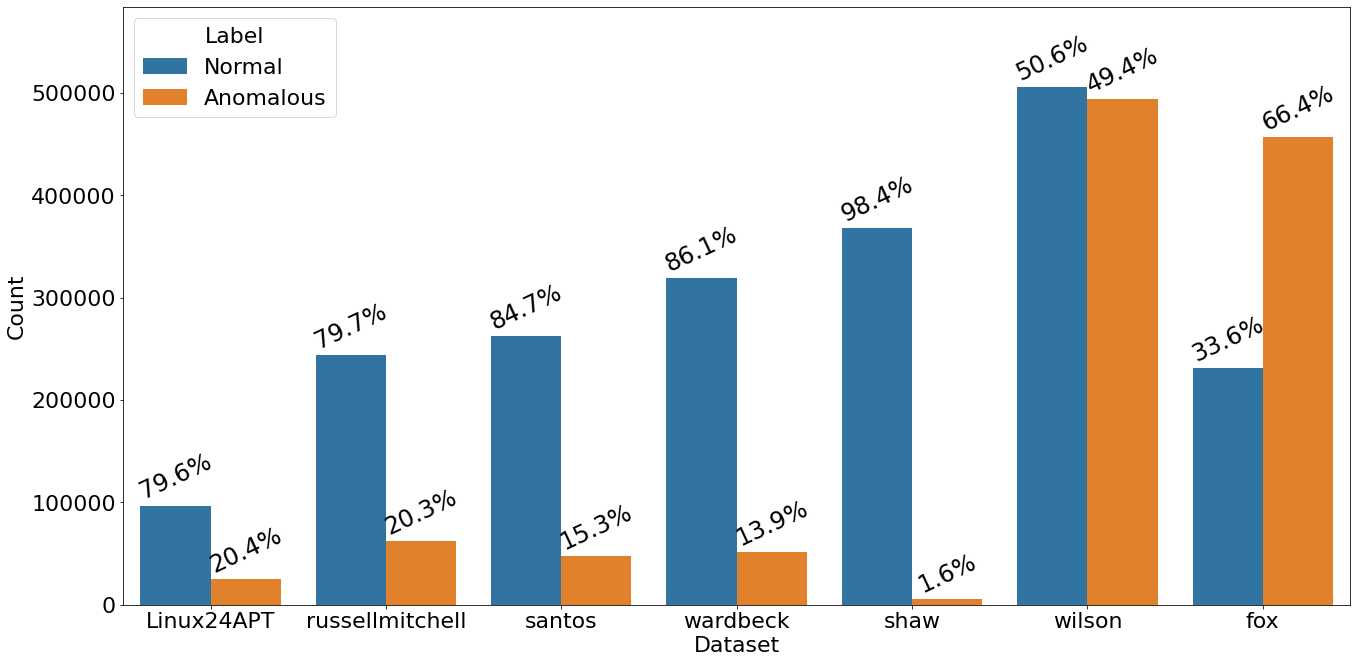

In [10]:
#Convert the dictionary to a DataFrame and reset the index
df = pd.DataFrame(counts).T.reset_index()
df = df.rename(columns={"index": "Dataset"})

# Melt the DataFrame to a long format suitable for Seaborn
# This creates separate rows for 'Normal' and 'Anomalous' counts
df_melted = df.melt(id_vars="Dataset", value_vars=["Normal", "Anomalous"],
                    var_name="Label", value_name="Count")

# --- New section to calculate percentages ---
# Create a dictionary mapping each Dataset to its Total count
total_counts = df.set_index('Dataset')['Total'].to_dict()

# Calculate the percentage for each row in the melted DataFrame
# The percentage is (Count / Total for that Dataset) * 100
df_melted['Percentage'] = df_melted.apply(
    lambda row: (row['Count'] / total_counts[row['Dataset']]) * 100,
    axis=1
)
# --- End of new section ---

# Set the figure size for better readability
plt.style.use('default')
plt.figure(figsize=(22, 11))

# Create the bar plot and store the Axes object
ax = sns.barplot(data=df_melted, x="Dataset", y="Count", hue="Label")

# Add the percentage labels on top of each bar
# ax.containers holds the groups of bars (one group for 'Normal', one for 'Anomalous')
for i, container in enumerate(ax.containers):
    # Get the correct percentage values for the current container (hue)
    # The order of hue is determined by the `value_vars` list in `melt`
    hue_label = ["Normal", "Anomalous"][i]
    labels = [f'{p:.1f}%' for p in df_melted[df_melted['Label'] == hue_label]['Percentage']]
    
    # Attach the labels to the bars in the container
    ax.bar_label(container, labels=labels, label_type='edge', fontsize=_FONT_SIZE, padding=2, rotation=25)
    

# Adjust the y-axis limit to give more space for the labels
ax.set_ylim(top=ax.get_ylim()[1] * 1.1)
ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=_FS)
ax.get_yaxis().set_tick_params(labelsize=_FS)


# Add titles and labels for clarity
# plt.title("Counts of Normal and Anomalous Labels per Dataset with Percentages")
plt.xlabel("Dataset", fontsize=_FS)
plt.ylabel("Count", fontsize=_FS)
plt.legend(title="Label", fontsize=_FS, title_fontsize=_FS)

# Display the plot
plt.show()

# Log Parsing